# 6. Metadata and Assessing Potential Bias
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Notably, geochemical databases are commonly not complete. They are typically sparse - for example, the EarthChem database has approximately 10% data density. Compounded with issues of geological overprinting, crustal recycling and destruction - these databases are unlikely to provide an unbiased view of the past.

While the law of uniformitarianism (“the present is the key to the past”) has been widely used in geoscience, potential sampling biases must be considered regarding geological time, paleo-location and chemistry (particularly in deep time: “was *X* more common long ago, or was *X* just more likely to be preserved?”). In many cases, the specific geological question cannot be decoupled completely from the question regarding potential data bias.

Where possible, databases are complemented with additional publication data to fill gaps in time, space and chemistry.

### Data Coverage

As mentioned above, geochemical databases are rarely complete. Similarly, different geochemical components are recorded more commonly where they are in higher abundances (a 'detection limit' effect) - or known elements of utility (a selection bias; e.g. Rare Earth Elements La through Lu). Note that the fields with the lowest frequently recorded values have been removed from the dataset for memory efficiency. The least commonly recorded element in the EarthChem database is iodine!

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [2]:
import sys
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

sys.path.insert(0, './src')
from classification import Geochemistry
from plotting_tools import *
from datasource import load_df

In [3]:
%%memit
df = load_df('EarthChemData.pkl', dense=True)

peak memory: 1568.75 MiB, increment: 1458.26 MiB


In [4]:
cm = Geochemistry.TAS(rebuild=True)
classnames = cm.clsf.fclasses + ['none']
df['TAS'] = cm.classify(df).astype('category')
df['TAScolors'] = df['TAS'].map(lambda x: classnames.index(x)) # Use the index in the list for a simple colormap
df['TASRock'] = df['TAS'].map(lambda x: cm.clsf.fields.get(x,{'names': ['N/A']}).get('names')[0])

Text(0.5,0,'Count')

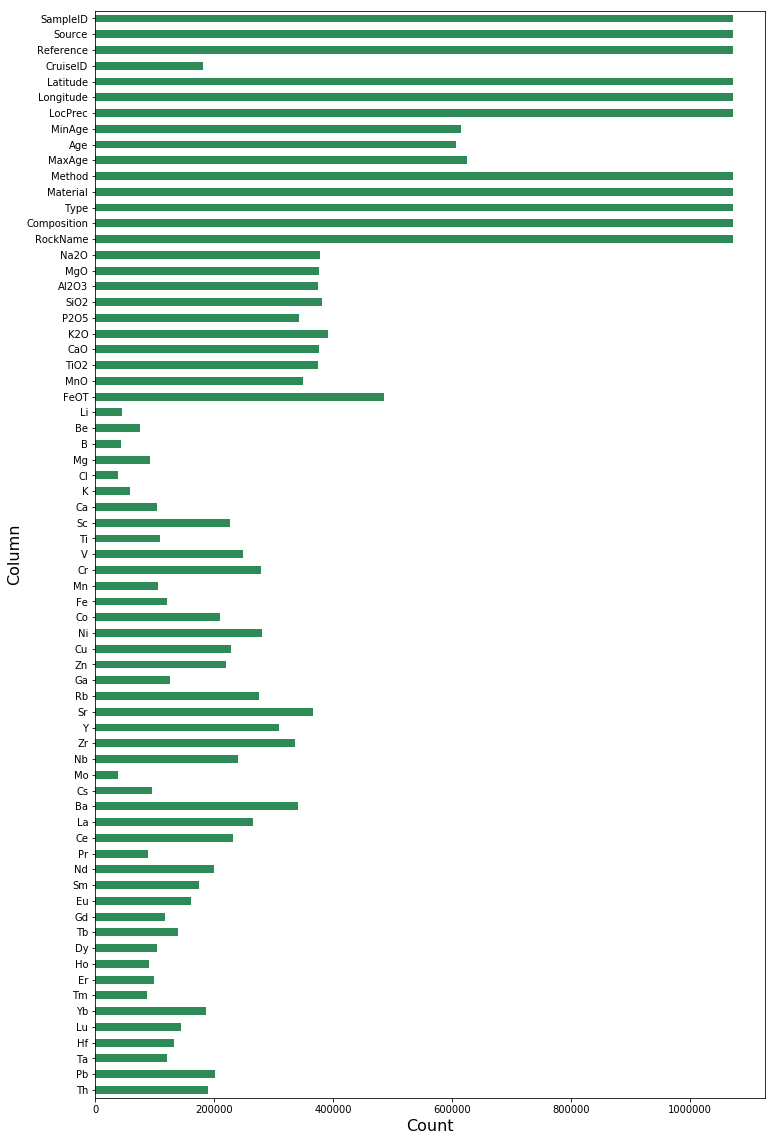

In [5]:
ax = df.iloc[:, :-5].count()[::-1].plot.barh(figsize=(12, 20), logx=False, color='seagreen');
ax.set_ylabel('Column', fontsize=16)
ax.set_xlabel('Count', fontsize=16);

### Age Distribution

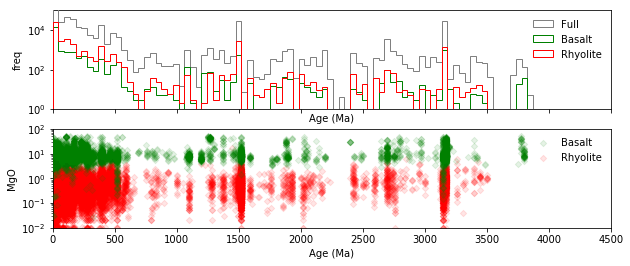

In [6]:
fig, ax = plt.subplots(2, 1,figsize=(10,4), sharex=True)
bins=100
f, a, r = age_distribution(df, yvar=None, agevar='Age', ax=ax[0], bins=bins, color='0.5', zorder=3, histtype='step', label='Full')
ax[0].set_yscale('log')
ax[0].set_ylabel('freq')
ax[0].set_xlim((0, 4500))
ax[0].set_ylim((1, 100000))
yvar = 'MgO'
agevar = 'Age'
filt = (~pd.isnull(df.loc[:, agevar])) & (~pd.isnull(df.TASRock)) & (~pd.isnull(df.loc[:, yvar])) # filter for speed
for rock_type, style in [('Basalt', dict(c='g', alpha=0.1, s=20, marker='D', zorder=3)),
                         ('Rhyolite', dict(c='r', alpha=0.1, s=20, marker='D', zorder=2)),
                        ]:
    
    rockdf = df.loc[df.TASRock == rock_type, :]
    f, a, r = age_distribution(rockdf, yvar=yvar, agevar=agevar, ax=ax[1], label=rock_type, **style)
    age_distribution(rockdf, yvar=None, ax=ax[0], bins=bins,
                     color=style['c'], zorder=3, histtype='step', label=rock_type)
    a.set_yscale('log')
    a.set_ylim((0.01, 100))

ax[0].legend(frameon=False)
ax[1].legend(frameon=False);

### Spatial Distribution

Geological samples are not collected equally. As would be expected, samples collected on land greatly outnumber samples collected from the ocean floor. Samples are most commonly collected from either current or previous plate boundaries - for good reason: these areas provide the most geological information, albeit also some of the most complicated. They also tend to have the best-exposed rocks ready for sampling.

C:\ProgramData\Miniconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\ProgramData\Miniconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


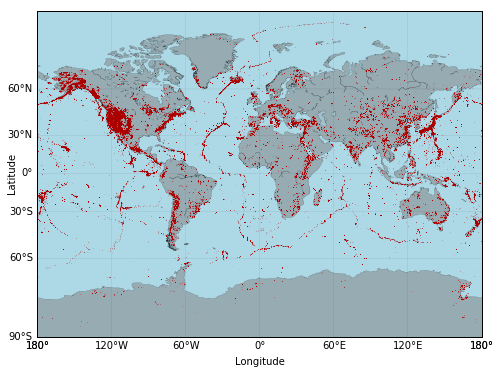

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 6))
ax=[ax]
ax[0].set_xlabel('Longitude', labelpad=20)
ax[0].set_ylabel('Latitude', labelpad=20)
bmp = Basemap(ax=ax[0], projection='mill', lon_0=0, resolution='l')
bmp.drawcoastlines(linewidth=0.1)
bmp.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0], linewidth=0.1)
bmp.drawmeridians(np.arange(bmp.lonmin, bmp.lonmax + 30,60), labels=[0,0,0,1], linewidth=0.1)
bmp.drawmapboundary(fill_color='lightblue')
bmp.fillcontinents(color='0.5', lake_color='lightblue', alpha=0.5)

filt = (df.Material == 'IGNEOUS') & (~pd.isnull(df.Latitude)) & (~pd.isnull(df.Longitude)) # filter for speed
plot_latlong(df.loc[filt, :], bmp, ax=ax[0], alpha=0.1, linewidth=0, color='red', marker='D', s=0.1, zorder=3)

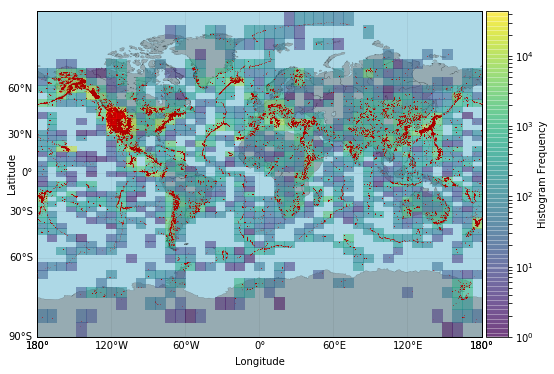

In [8]:
nx, ny = 45, 45
lon_bins = np.linspace(-180, 180, nx+1)
lat_bins = np.linspace(-90, 90, ny+1)

heatmap, _, _ = np.histogram2d(df.loc[filt, 'Longitude'], df.loc[filt, 'Latitude'], bins=[lon_bins, lat_bins])
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
xs, ys = bmp(lon_bins_2d, lat_bins_2d)
im  = ax[0].pcolormesh(xs, ys, heatmap.T, 
                       alpha=0.5,
                       norm=LogNorm(),
                       cmap='viridis',
                       zorder=2)
cb = colorbar(im, shrink=0.8,)
cb.set_label('Histogram Frequency')
fig